# Build an ML model to predict how fast I should be able to run a race

### Kyle Willett ([@willettk](https://github.com/willettk))

24 Jul 2017

In [1]:
%matplotlib inline

In [2]:
# Get those packages

import pandas as pd
import datetime
import numpy as np
from IPython.display import display

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
# Data from my website
url = "http://willettk.github.io/racelist.html"

In [4]:
# Load data. God bless pandas.read_html. 

table_list = pd.read_html(url,parse_dates=True)
run_raw = table_list[0]

# Rename columns for some easier typing
rc = run_raw.columns
run_raw.rename(columns={rc[0]:"date",
                    rc[1]:"race",
                    rc[2]:"d_km",
                    rc[3]:"d_mi",
                    rc[4]:"location",
                    rc[5]:"time",
                    rc[6]:"pace",
                    rc[7]:"place_overall",
                    rc[8]:"finishers_overall",
                    rc[9]:"place_division",
                    rc[10]:"finishers_division",
                    rc[11]:"division"
                   }
           ,inplace=True)

# Ditch the couple races where finishing data
# is probably inaccurate, based on lack of pace
run = run_raw[[False if type(x) == float and np.isnan(x) else True for x in run_raw.pace]].copy()

In [5]:
# Manual mapping of run type (trail or road)

runtype = ["R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "T", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "T", "T", "T", "R", "T", "R", "R", "T", "T", "T", "R", "T", "T", "R", "T", "T", "R", "R", "R", "T", "R", "R", "R", "R", "R", "R", "R", "T", "T", "R", "R", "R", "T", "R", "R", "R", "T", "T", "T", "R", "R", "R", "R", "T", "T", "R", "R", "T", "R", "R", "R", "R", "R", "R", "T", "T", "R", "R", "T", "R", "T", "R", "R", "R", "T", "R", "R", "R", "T", "R", "T", "T", "R", "R", "T", "T", "T", "R", "T", "R", "R", "R", "R", "R", "R", "R", "R", "T", "T", "R", "R", "T", "T", "T", "R", "T", "T","T","T","T","R","T"]
run['runtype'] = runtype

In [6]:
run_columns = ['date','race','d_mi','runtype','location','time','pace','place_overall','finishers_overall','place_division','finishers_division']
dt = run[run_columns].copy()

try:
    dt['date'] = pd.to_datetime(dt.date)
except AttributeError:
    print(dt)
    
dt['pace'] = [datetime.timedelta(minutes=float(x.split()[0].split(':')[0]),
                                     seconds=float(x.split()[0].split(':')[1])) for x in dt.pace]

time_td = []
for x in dt.time:
    xs = x.split(':')
    if len(xs) == 3:
        td = datetime.timedelta(hours=float(xs[0]),
                             minutes=float(xs[1]),
                             seconds=float(xs[2]))
        time_td.append(td)
    elif len(xs) == 2:
        td = datetime.timedelta(minutes=float(xs[0]),
                             seconds=float(xs[1]))
        time_td.append(td)
    else:
        print("{} did not have format of HH:MM:SS or MM:SS".format(x))
        
dt['time'] = time_td
        
# Filter to only races with data on number and division of other finishers
dtf = dt[np.isfinite(dt['finishers_overall']) & np.isfinite(dt['finishers_division'])].copy()
for c in dtf.columns[-4:]:
    dtf[c] = dtf[c].astype(int)

In [7]:
dtf['label'] = [x.seconds for x in dtf['time']]
dtf['month'] = [x.month for x in dtf['date']]
dtf['year'] = [x.year for x in dtf['date']]
dtf['season'] = ['S' if x.month >= 5 and x.month <=10 else 'W' for x in dtf['date']]

dtf

,date,race,d_mi,runtype,location,time,pace,place_overall,finishers_overall,place_division,finishers_division,label,month,year,season
6,1999-09-06,Victory 10K,6.200,R,"Minneapolis, MN",00:51:30,00:08:18,488,640,6,6,3090,9,1999,S
9,2000-03-19,The Human Race,3.100,R,"St. Paul, MN",00:24:12,00:07:48,58,713,2,3,1452,3,2000,W
10,2000-04-29,Get in Gear,6.200,R,"Minneapolis/St. Paul, MN",00:49:21,00:07:58,1070,2741,211,492,2961,4,2000,W
11,2000-06-04,Grand Old Day on the Go,5.000,R,"St. Paul, MN",00:36:41,00:07:23,203,566,6,7,2201,6,2000,S
12,2000-06-24,Run for the Roses,3.100,R,"Roseville, MN",00:21:59,00:07:05,41,150,10,20,1319,6,2000,S
13,2000-09-04,Victory 10K,6.200,R,"Minneapolis, MN",00:44:55,00:07:15,355,724,4,6,2695,9,2000,S
15,2001-03-18,The Human Race,3.100,R,"St. Paul, MN",00:23:31,00:07:35,42,622,2,3,1411,3,2001,W
16,2001-04-28,Get in Gear,6.200,R,"Minneapolis/St. Paul, MN",00:48:48,00:07:52,933,4563,178,501,2928,4,2001,W
17,2001-06-03,Grand Old Day on the Go,5.000,R,"St. Paul, MN",00:36:56,00:07:26,257,1129,2,5,2216,6,2001,S
18,2001-06-23,Run for the Roses,3.100,R,"Roseville, MN",00:21:39,00:06:59,62,453,11,16,1299,6,2001,S


Features I can use:

- distance
- year
- month of year
- season (binary)
- trail vs road

In [8]:
le = LabelEncoder()
le.fit(dtf['season']);

dtf['season_enc'] = le.transform(dtf['season'])

le2 = LabelEncoder()
le2.fit(dtf['runtype']);

dtf['runtype_enc'] = le2.transform(dtf['runtype'])

In [9]:
X = dtf[['d_mi','year','month','season_enc','runtype_enc']]
y = dtf[['race','label']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [10]:
rf = RandomForestRegressor(n_estimators=10
                            ,criterion='mse'
                            ,max_depth=5
                            ,min_samples_split=2
                            ,min_samples_leaf=1
                            )

rf.fit(X_train,y_train['label']);
pred = rf.predict(X_test)

In [11]:
def time_formatting(t,verbose=False):
    # Output times in something sensibly human-readable
    if t.seconds > 3600:
        if verbose:
            print("Formatting as HH:MM:SS")
        timestr = "{:2.0f}:{:02.0f}:{:02.0f}".format(int(t.seconds / 3600), int((t.seconds % 3600)/60), t.seconds % 60 )
    elif t.seconds > 60:
        if verbose:
            print("Formatting as MM:SS")
        timestr = "   {:2.0f}:{:02.0f}".format(int(t.seconds / 60), t.seconds % 60 )
    else:
        if verbose:
            print("Formatting as SS")
        timestr = "      {:.0f}".format(t.seconds)

    return timestr

In [12]:
df = pd.DataFrame()

time_pred = []
time_real = []
time_diff = []
time_perc = []

for x,y,distance,race in zip(pred
                              ,y_test['label']
                              ,X_test['d_mi']
                              ,y_test['race']):
    t_pred = time_formatting(datetime.timedelta(seconds=np.float(x)))
    t_actual = time_formatting(datetime.timedelta(seconds=np.float(y)))
    t_diff = (x - y)
    t_perc = (x - y)/y * 100.
    print("{} predicted; {} actual time. Off by {:5.0f} sec ({:5.1f}%). Race: {:4.1f} miles, {}".format(t_pred
                                                                                              ,t_actual
                                                                                              ,t_diff
                                                                                              ,t_perc
                                                                                              ,distance
                                                                                              ,race))
    time_pred.append(t_pred)
    time_real.append(t_actual)
    time_diff.append(t_diff)
    time_perc.append(t_perc)
    
df['time_pred'] = time_pred
df['time_real'] = time_real
df['diff'] = time_diff
df['perc'] = time_perc
df['distance'] = X_test.reset_index()['d_mi']
df['race'] = y_test.reset_index()['race']
df['year'] = X_test.reset_index()['year']

 4:01:42 predicted;  3:21:42 actual time. Off by  2401 sec ( 19.8%). Race: 26.2 miles, Grandma's Marathon
   10:57 predicted;     5:38 actual time. Off by   319 sec ( 94.5%). Race:  1.0 miles, Meet of the Miles
 1:06:11 predicted;  1:03:26 actual time. Off by   165 sec (  4.3%). Race: 10.0 miles, TC 10 Mile
   45:58 predicted;    45:10 actual time. Off by    48 sec (  1.8%). Race:  7.0 miles, MDRA 7 Mile
 6:14:13 predicted;  5:51:21 actual time. Off by  1373 sec (  6.5%). Race: 34.2 miles, Moab's Red Hot 55K
 1:22:54 predicted;  1:07:08 actual time. Off by   947 sec ( 23.5%). Race: 10.0 miles, Bridle Trails Winter Running Festival
 2:02:49 predicted;  2:12:36 actual time. Off by  -586 sec ( -7.4%). Race: 15.5 miles, Afton Trail Run
   38:59 predicted;    36:41 actual time. Off by   139 sec (  6.3%). Race:  5.0 miles, Grand Old Day on the Go
 1:59:48 predicted;  2:35:05 actual time. Off by -2116 sec (-22.7%). Race: 15.5 miles, Bandera Trail Races
   41:43 predicted;    38:38 actual time

## How accurate is the model?

In [13]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,r2_score

y_true = y_test['label']
y_pred = pred
print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_true,y_pred))))
print("MAE:  {:.4f}".format(mean_absolute_error(y_true,y_pred)))
print("EVS:  {:.4f}".format(explained_variance_score(y_true,y_pred)))
print("R^2:  {:.4f}".format(r2_score(y_true,y_pred)))

RMSE: 3935.8053
MAE:  1377.6803
EVS:  0.7906
R^2:  0.7817


## How do results stack up by category?

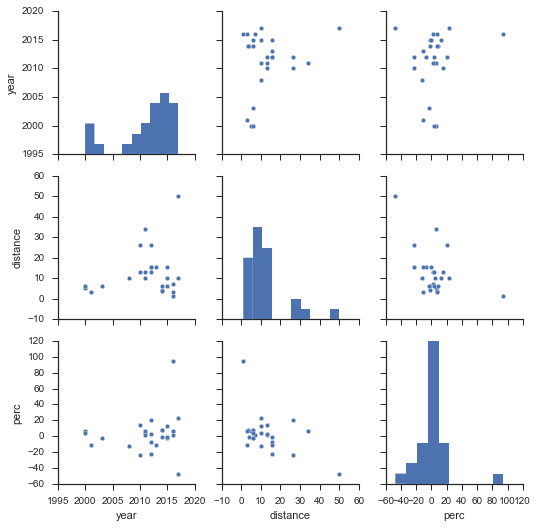

In [14]:
sns.set(style="ticks")
sns.pairplot(df[['year','distance','perc']]);

Ideas for adding new features, improving model:

- tune hyperparameters
- try a different classifier
- add new features:
  - starting elevation
  - total elevation gain (scrape Strava and/or race websites, assume zero for most sea-level races)
- train separate models for road and trail races
